# EEEN30101 Numerical Analysis

# Week 04 - Part 02

***&copy; 2024 Martínez Ceseña — University of Manchester, UK***

This notebook introduces covers the second half of the contents presented in week 04. To be more specific, the notebook addresses:
- Analysis of search algorithms using Rosenbrock's banana function
- Constrained optimisation
- Non-convex optimisation

The use of the notebooks is optional and will not be marked. That said, you are strongly encouraged to play with the tools and examples, as you can explore different variations of the examples, which will better prepare you for the exams.

## List of contents

- [Python code](#Python-code)


- [Banana function](#Banana-function)
  - [Search algorithms](#Search-algorithms)
  - [Steepest descend](#Steepest-descend)
  - [Newton's search](#Newton's-search)


- [Constrained optimisation](#Constrained-optimisation)
  - [Optimisation constraints](#Optimisation-constraints)
  - [Barrier functions](#Barrier-functions)
  - [Interior point algorithm](#Interior-point-algorithm)
  - [Convexity](#Convexity)


- [Non-convex optimisation](#Non-convex-optimisation)
  - [Non-convex functions](#Non-convex-functions)
  - [Simulated annealing](#Simulated-annealing)
  - [Algorithm](#Algorithm)


- [Conclusion](#Conclusion)

## Before we begin

Before we begin: 
- Make sure to review the asynchronous materials provided in blackboard for EEEN30101 Week 4 
- If you have any questions, please post them in the discussion boards or, if that is not possible, send an email to alex.martinezcesena@manchester.ac.uk

This notebook provides some examples in python, for that purpose the following libraries will be loaded:

In [1]:
import math  # To use mathematical operation
import numpy as np  # To define and use matrices
import matplotlib
import matplotlib.pyplot as plt  # To plot figures
import copy

# To create an interface to the code
try:
    import ipywidgets as widgets
except:
    import micropip
    await micropip.install('ipywidgets')
    import ipywidgets as widgets
from ipywidgets import interact

[Back to top](#EEEN30101-Numerical-Analysis)

## Python code

This notebook requires some algorithms that were developed in part 01, which have been added below. Please review part 01 if you need more information about these algorithms.

- Methods to plot 2D figures:

In [2]:
def plotFigure(X, Y, Label=[], xlabel='x', ylabel='J(x)', ax=math.nan):
    '''Plot a figure'''
    if str(ax.__class__) != '<class \'matplotlib.axes._subplots.AxesSubplot\'>':
        fig, ax = plt.subplots()

    for i in range(X.shape[0]):
        line, = ax.plot(X[i], Y[i], label=Label[i])

    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.grid()
    if '_child' not in line.get_label():
        plt.legend()
    plt.show()

def addPoints(ax, X, Y, Label1, Label2, Dx, Dy):
    '''Add points to figure'''
    mY= min(Y)
    for i in range(len(X)):
        ax.plot(X[i], Y[i], '*')
        ax.text(X[i]-Dx, mY-Dy, Label1[i])
        ax.text(X[i]+Dx, Y[i], Label2[i])

def plotFullFigures(X, Y, Label1, Label2, xlabel='x',
                    ylabel='J(x)', x=[0], y=[0], Label=['']):
    '''Plot a figure with both points and lines'''
    Dx = (max(X)-min(X))*2/100
    Dy = max( (max(Y)-min(Y))*2/10, (np.max(y)-np.min(y))*3/10)
    
    fig, ax = plt.subplots()

    addPoints(ax, X, Y, Label1, Label2, Dx, Dy)

    plotFigure(x, y, Label, xlabel, ylabel, ax)

- Method to plot scatter 3D figures:

In [3]:
def plot3D(ex, T = 20, X=[-5, 5], Y=[-5, 5], prt=False):
    '''Plot 3D scatter'''
    fig = plt.figure(figsize=(6, 6))
    ax = plt.axes(projection='3d')

    v1 = np.linspace(X[0], X[1], T)
    v2 = np.linspace(Y[0], Y[1], T)
    x1 = np.zeros((T**2))
    x2 = np.zeros((T**2))
    x3 = np.zeros((T**2))
    x = np.zeros((2, 1))
    k = 0
    for i in range(T):    
        for j in range(T):
            x1[k] = v1[i]
            x2[k] = v2[j]
            x[0] = x1[k]
            x[1] = x2[k]
            x3[k] = ex.get_value(x)
            k+=1
   
    ax.scatter(x1, x2, x3)
    
    x = ex.get_optimal()
    ax.scatter(x.item(0), x.item(1), x.item(2), color='black')
    Dz = min(x3) - (max(x3)-min(x3))*0.1
    ax.text(x.item(0), x.item(1), Dz, "x*", color='black')

    ax.set(xlabel='(x)', ylabel='(y)', zlabel='(z)')
    plt.show()

    if prt:
        print('x* = [%.4f, %.4f, %.4f]'%(x.item(0), x.item(1), x.item(2)))

- Method for contour plots:

In [4]:
def plotContour(ex, delta = 1, X=[-5, 5], Y=[-5, 5], prt=False, L=[], P=[]):
    '''Contour plot'''
    x = np.arange(X[0], X[1], delta)
    y = np.arange(Y[0], Y[1], delta)
    x, y = np.meshgrid(x, y)

    s = x.shape
    z = np.zeros((s), dtype = np.float64)
    for i in range(s[0]):
        for j in range(s[1]):
            z[i, j] = ex.get_value(np.transpose(np.matrix([x[i,j],y[i,j]], dtype = np.float64)))

    fig, ax = plt.subplots()
    CS = ax.contour(x, y, z)
    ax.clabel(CS, inline=True, fontsize=10)

    if len(L)>0:  # Adding lines (e.g. barrier functions)
        ax.plot([L[0,0], L[0,1]], [L[1,0], L[1,0]], color='black')
        ax.plot([L[0,0], L[0,1]], [L[1,1], L[1,1]], color='black')
        ax.plot([L[0,0], L[0,0]], [L[1,0], L[1,1]], color='black')
        ax.plot([L[0,1], L[0,1]], [L[1,0], L[1,1]], color='black')

    Dx = (X[1]-X[0])*0.04
    if len(P)>0:  # Adding points (e.g., constrained optimal point)
        ax.scatter(P.item(0), P.item(1), color='blue')
        ax.text(P.item(0)+Dx, P.item(1), "x*", color='blue')

    x_star = ex.get_optimal()
    ax.scatter(x_star.item(0), x_star.item(1), color='black')
    ax.text(x_star.item(0)-Dx, x_star.item(1), "x*", color='black')
    if prt:
        print('x* = [%.4f, %.4f, %.4f]'%(x_star.item(0), x_star.item(1), x_star.item(2)))
    plt.show()

- Method to model polynomial functions:

In [5]:
def polynomial(x=[1], K=[1, 1]):
    '''Simulate value of polynomial'''
    s1 = len(x)
    s2 = len(K)
    y = np.zeros((s1))
    for i in range(s1):
        for j in range(s2):
            y[i] += K[j]*x[i]**j

    return y

- Method for the golden search:

In [6]:
def goldenSearch(ex, Xu, Xb, prt=False):
    '''Golden section search'''
    tau = (-1+math.sqrt(5))/2
    Wu = Xb - tau*(Xb-Xu)
    Wb = Xu + tau*(Xb-Xu)
    
    Ju = ex.get_value(Wu)
    Jb = ex.get_value(Wb)
    
    if prt:
        xu = "\u0332".join("x ")
        xb = "\u0305".join("x ")
        wu = "\u0332".join("w ")
        wb = "\u0305".join("w ")
        print("       "+xu+"       "+wu+"       "+wb+"       "+xb+
              "  J( "+wu+")"+"   J( "+wb+")"+"     "+wu+"-"+xu+
              "    "+xb+"-"+wb+"    "+xb+"-"+xu+"   Ratio")    
    Error = 1000
    k = 0
    while Error > 0.0001:
        if prt:
            print('%8.4f %8.4f %8.4f %8.4f %8.4f %8.4f %8.4f %8.4f %8.4f %8.4f'
                  %(Xu, Wu, Wb, Xb, Ju, Jb, Wu-Xu, Xb-Wb, Xb-Xu, (Wb-Xu)/(Xb-Xu)))
        if Ju < Jb:
            Xb = Wb
            J1 = Jb
            Wb = Wu
            Jb = Ju
            Wu = Xb - tau*(Xb-Xu)
            Ju = ex.get_value(Wu)
        else:
            Xu = Wu
            J0 = Ju
            Wu = Wb
            Ju = Jb
            Wb = Xu + tau * (Xb-Xu)
            Jb = ex.get_value(Wb)

        if len(Xu) == 1:
            Error = math.sqrt((Wu[0]-Xb[0])**2)
        else:
            Error = math.sqrt((Wu[0]-Xb[0])**2+(Wu[1]-Xb[1])**2)
        
        k += 1
        if k>50:
            print('Golden section search failed after %d iterations'%k)
            Error = 0
    x_star = Wb
    if k <= 50 and prt:
        print('%8.4f %8.4f %8.4f %8.4f'%(Xu, Wu, Wb, Xb))
        print('\nConvereged to %.4f after %d iterations'%(x_star,k))

    return x_star

- Method to represent the first example:

In [7]:
class Example1:
    def __init__(self, H, f):
        '''Initializing function'''
        self.H = H
        self.f = f
        self.No = len(f)
        self.x = np.zeros((self.No+1,1))

    def get_value(self, x):
        '''Get value of the function'''
        J = 0.5 *np.matmul(np.transpose(x),np.matmul(self.H,x)) + \
            np.matmul(np.transpose(self.f),x)
        return J

    def get_optimal(self):
        '''Get optimal value'''
        Hi = np.linalg.inv(self.H)
        self.x[0:self.No] = - np.matmul(Hi, self.f)
        self.x[self.No] = - 0.5 *np.matmul(np.transpose(self.f),np.matmul(Hi,self.f))

        return self.x

[Back to top](#EEEN30101-Numerical-Analysis)

## Banana function

In this section, we will explore the applications of a couple of optimisation algorithms using an established multi-dimensional test system, namely Rosenbrock's banana function.

### Search algorithms

Rosenbrock's banana function is an established equation that is typically used to test gradient based optimisation algorithms.

The equation is a function of two variables ($x_1$ and $x_2$) as shown below.

$$ J(x_1,x_2) = (1-x_1)^2 + 100 (x_2-x_1^2)^2 $$

One of the advantages of using this equation, is that we can identify the optimum value ($\underline{x}^*$ just by inspecting the equation. That is
- $(1-x_1)^2$ will always be a positive number. The lowest value we can get is when $x_1=1$, i.e., $(1-1)^2 = 0$
- $100(x_2-x_1^2)^2$ will also always be positive. The lowest value we can get is when $x_1=x_2=1$, i.e., $100(1-1^2)^2 = 0$

$$ \underline{x}^* = \left[ \begin{array}{c} 1 \\ 1 \end{array} \right]$$

Use the following python method to explore the characteristics of the function.

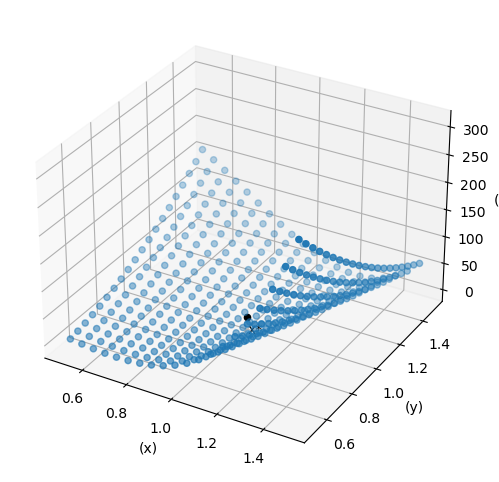

x* = [1.0000, 1.0000, 0.0000]


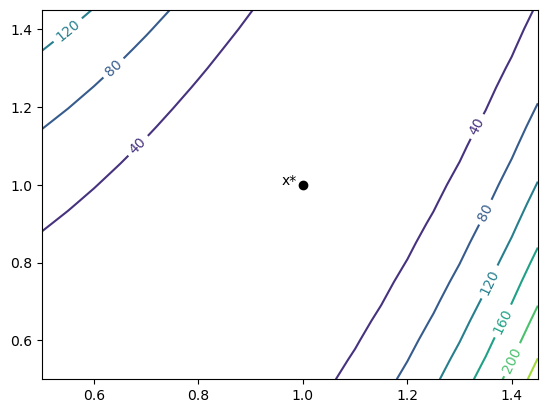

In [8]:
class Banana:
    def __init__(self, K=[1, 100]):
        '''Initializing function'''
        self.K = K
        self.x = np.zeros((3, 1))

    def get_value(self, x):
        '''Get value of the function'''
        J = (self.K[0]-x[0])**2 + self.K[1]*(x[1] - x[0]**2)**2

        return J

    def get_optimal(self):
        '''Get optimal value'''
        self.x[0] = self.K[0]
        self.x[1] = self.x[0]**0.5
        self.x[2] = self.get_value(self.x)

        return self.x

ex2 = Banana([1, 100])
plot3D(ex2, 20, [0.5, 1.5], [0.5, 1.5])
plotContour(ex2, 0.05, [0.5, 1.5], [0.5, 1.5], True)

Let us now define a search algorithm to find the optimal values of $x_1$ and $x_2$ that minimise the value of the function.

The algorithm should:

- find a direction $\Delta x_[k]$ where the optimal solution may be


- update the current solution (guess) by moving it a given distance ($\lambda$) in the selected direction

$$ x_{k+1} = x_k + \lambda_k \Delta x_k$$

- Continue the process until a solution is found.

In summary, the algorithm will look like this:

**Search algorithm**

`WHILE termination conditions not met`<br/>
`    Pick a direction dk`<br/>
`    Scale it`<br/>
`END WHILE`


Such an algorithm is presented below. 

In [9]:
def SearchAlgorithm(ex, SA, x, N=20, prt=False):
    '''Search algorithm'''
    k = 0
    Error = 1000
    s = len(x)

    while Error > 0.0001:
        # Pick a direction  Δ𝑥
        df = SA.get_step(ex, x)
        x0 = x*1
        x1 = x-df

        # Scale it with  Λ𝑘  (Golden section search)
        x = goldenSearch(ex, x0, x1)
        k += 1
        if prt:
            print('%3.0f,  %10.4f %10.4f'%(k, x[0], x[1]))

        if k==N:
            Error = 0
            print('Failed to converge after %d iterations'%k)
            print('The last result was [%.4f, %.4f]'%(x[0], x[1]))
        else:
            Error = SA.get_error(ex, x)

    if k<N:
        print('Converged to [%.4f, %.4f]'%(x[0], x[1]))
        print(' After %d iterations'%k)

    return x, k

The search algorithm scales the direction of the search with a golden section search (developed in the previous section).

To identify the direction required to update the solution, we will explore two methods in the following subsections:
- **Steepest descent**, which is based on the first derivatives of the function, i.e., the gradient of the function (called Jacobian in matrix form), and
- **Newton's method**, which extends the search to also consider the second derivatives of the function (Hessian matrix).

[Back to top](#EEEN30101-Numerical-Analysis)

### Steepest descend

The gradient is obtained with first derivatives of the function with respect to each variable at a time ($x_1$ and $x_2$ in our example):

$$
\begin{aligned}
  \frac{\partial J (\underline{x})}{\partial x_1} & = \frac{\partial}{\partial x_1} \left[ (1-x_1)^2 + 100 (x_2-x_1^2)^2 \right[\\
   & = 2 (1-x_1)^{2-1} \frac{\partial (1-x_1)}{\partial x_1} + 100(2) (x_2-x_1^2)^{2-1} \frac{\partial (x_2-x_1^2)}{\partial x_1}\\
   & = 2(1-x_1)(-1) + 200 (x_2-x_1^2)(-2x_1)\\
   & = 2(x_1-1) + 400 (x_1^2 - x_2)x_1
\end{aligned}
$$

$$
\begin{aligned}
  \frac{\partial J (\underline{x})}{\partial x_2} & = \frac{\partial}{\partial x_2} \left[ (1-x_1)^2 + 100 (x_2-x_1^2)^2 \right[\\
   & = 0 + 100(2) (x_2-x_1^2)^{2-1} \frac{\partial (x_2-x_1^2)}{\partial x_2}\\
   & = 200 (x_2-x_1^2)
\end{aligned}
$$

Accordingly, our gradient looks like this:

$$\bigtriangledown J( \underline{x}) = \left[ \begin{array}{c} \partial J (\underline{x})/\partial x_1 \\ \partial J (\underline{x})/\partial x_2 \end{array} \right] = \left[ \begin{array}{c} 2(x_1-1) + 400 (x_1^2 - x_2)x_1 \\ 200 (x_2-x_1^2) \end{array} \right]$$

Use the python method below to explore these functions.

In [10]:
@interact
def TestGradient(x1 = widgets.FloatSlider(min=-10, max = 10, value=0, description='x1: ', continuous_update=False),
               x2 = widgets.FloatSlider(min=-10, max = 10, value=0, description='x2: ', continuous_update=False)):
    
    dJx1 = 2*(x1-1) + 400*(x1**2-x2)*x1
    dJx2 = 200*(x2-x1**2)
    print('Algebraical differentiation:')
    print('∂𝐽(𝑥1,x2)/∂𝑥1 = %f'%dJx1)
    print('∂𝐽(𝑥1,x2)/∂𝑥2 = %f'%dJx2)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x1: ', max=10.0, min=-10.0)…

The equations developed above are only valid for Rosenbrock's banana function, and new equations would have to be developed for other functions.

In order to develop a more general model that can consider other equations, numerical differentiation is used. ***Numerical differentiation will be discussed in detail in a few weeks***.

Use the python method below to confirm that numerical differentiation provides reasonable approximations of the gradient.

In [11]:
def numDiff(ex, x, Dv = 0.0001):
    '''Numerical differentiation'''
    val0 = ex.get_value(x)
    
    s = len(x)
    dff = np.zeros((s,1))
    for i in range(s):
        dx = copy.deepcopy(x)
        dx[i] = x[i]+Dv
        dv = ex.get_value(dx)

        dff[i] = (dv - val0)/Dv

    return dff

@interact
def TestNumDiff(x1 = widgets.FloatSlider(min=-10, max = 10, value=0, description='x1: ', continuous_update=False),
               x2 = widgets.FloatSlider(min=-10, max = 10, value=0, description='x2: ', continuous_update=False),
               Threshold=widgets.BoundedFloatText(min=0.0000001, max = 1, value=0.0001, description='Threshold')):
    
    x = np.transpose(np.matrix([x1,x2], dtype = np.float64))
    diff = numDiff(ex2, x, Threshold)
    print('Numerical differentiation:')
    print('∂𝐽(𝑥1,x2)/∂𝑥1 = %f'%diff[0])
    print('∂𝐽(𝑥1,x2)/∂𝑥2 = %f'%diff[1])

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x1: ', max=10.0, min=-10.0)…

We can now use the equations to optimise the banana function using steepest descent.

In [12]:
class Steep():
    def get_step(self, ex, x):
        '''Get step of steepest descent'''
        val = numDiff(ex, x)
        aux = math.sqrt(val[0]**2+val[1]**2)
        val = [val[0]/aux, val[1]/aux]
        
        self.dt = np.matrix(val, dtype = np.float64)

        return self.dt

    def get_error(self, ex, x):
        '''Get error of steepest descent'''
        Error = 0
        for i in range(len(x)):
            Error += abs(self.dt[i])
        return Error

@interact
def TestSteep(x1 = widgets.FloatSlider(min=-2, max = 2, value=0, description='x1: ', continuous_update=False),
              x2 = widgets.FloatSlider(min=-2, max = 2, value=0, description='x2: ', continuous_update=False),
              N = widgets.IntSlider(min=10, max = 300, value=20, description='Max. Iter.: ', continuous_update=False)):
    x = np.transpose(np.matrix([x1, x2], dtype = np.float64))
    x, k = SearchAlgorithm(ex2, Steep(), x, N, True)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x1: ', max=2.0, min=-2.0), …

Based on the studies above, the steepest search above takes a large number of iterations to converge when finding the solution of the banana function. 

This can be attribute to the shape of the function, which has a low gradient near the optimal point. We can probably do better if we were to consider the curvature of the function with the second derivative of the function.

[Back to top](#EEEN30101-Numerical-Analysis)

### Newton's search

In order to apply Newton's search to find a solution for the banana function, we will have to develop the Hessian matrix. The process is presented below.

The second derivative of the function with respect to $x_1$ is:

$$
\begin{aligned}
  \frac{\partial J (\underline{x})}{\partial x_1^2} & = \frac{\partial}{\partial x_1} \left[ 2(x_1-1) + 400 (x_1^2 + x_2)x_1 \right[\\
   & = 2 + 400 \left[ (x_1^2 + x_2) \frac{\partial x_1}{\partial x_1} + x_1 \frac{\partial}{\partial x_1}(x_1^2 + x_2) \right]\\
   & = 2 + 400 \left[ (x_1^2 + x_2)(1) + x_1 (2x_1) \right]\\
   & = 2 + 400 \left[ x_1^2 + x_2 + 2x_1^2 \right] \\
   & = 2 + 1200 x_1^2 + 400 x_2
\end{aligned}
$$

The second derivative of the function with respect to $x_2$ is:

$$
\begin{aligned}
  \frac{\partial J (\underline{x})}{\partial x_2^2} & = \frac{\partial}{\partial x_2} \left[ 200 (x_2-x_1^2) \right[\\
   & = 200
\end{aligned}
$$

The derivative of the function to $x_1$ and $x_2$ is:

$$
\begin{aligned}
  \frac{\partial J (\underline{x})}{\partial x_2 \partial x_1} = \frac{\partial J (\underline{x})}{\partial x_1 \partial x_2}& = \frac{\partial}{\partial x_1} \left[ 200 (x_2-x_1^2) \right[\\
   & = -400 x_1
\end{aligned}
$$

We can now form the Hessian matrix as follows:

$$\underline{\underline{H}} = \left[ \begin{array}{cc} \partial J (\underline{x})/\partial x_1^2 & \partial J (\underline{x})/\partial x_1 x_2\\ \partial J (\underline{x})/\partial x_2 x_1& \partial J (\underline{x})/\partial x_2^2\end{array} \right] = \left[ \begin{array}{cc} 2 + 1200 x_1^2 + 400 x_2 & -400x_1 \\ -400x_1 & 200 \end{array} \right]$$

Use the python method below to analyse the Hessian matrix.

In [13]:
@interact
def TestGradient(x1 = widgets.FloatSlider(min=-10, max = 10, value=0, description='x1: ', continuous_update=False),
               x2 = widgets.FloatSlider(min=-10, max = 10, value=0, description='x2: ', continuous_update=False)):
    
    dJx1x1 = 2+1200*x1**2+400*x2
    dJx1x2 = -400*x1
    dJx2x2 = 200

    print('Algebraical differentiation:')
    print('∂𝐽(𝑥1,x2)/∂𝑥1x1 = %f'%dJx1x1)
    print('∂𝐽(𝑥1,x2)/∂x1𝑥2 = %f'%dJx1x2)
    print('∂𝐽(𝑥1,x2)/∂𝑥2x1 = %f'%dJx1x2)
    print('∂𝐽(𝑥1,x2)/∂𝑥2x2 = %f'%dJx2x2)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x1: ', max=10.0, min=-10.0)…

As we did before with the gradient, numerical differentiation is used as a more general model that can take a variety of equations.

Use the python method below to confirm that numerical differentiation provides reasonable approximations of the Hessian.

In [14]:
def numDiff2(ex, x, Dv = 0.0001):
    '''Numerical differentiation'''
    # ∂𝐽(𝑥)/∂𝑥1, ∂𝐽(𝑥)/∂𝑥2, ..., ∂𝐽(𝑥)/∂𝑥n
    dff0 = numDiff(ex, x, Dv)

    s = len(x)
    dff = np.zeros((s,s))
    for i in range(s):
        dx = copy.deepcopy(x)
        dx[i] = x[i]+Dv
        dv = numDiff(ex, dx, Dv)

        aux= (dv - dff0)/Dv
        for j in range(s):
            dff[i, j] = aux[j]

    return dff

@interact
def TestGradient(x1 = widgets.FloatSlider(min=-10, max = 10, value=0, description='x1: ', continuous_update=False),
                x2 = widgets.FloatSlider(min=-10, max = 10, value=0, description='x2: ', continuous_update=False),
                Threshold=widgets.BoundedFloatText(min=0.0000001, max = 1, value=0.0001, description='Threshold')):
    x = np.transpose(np.matrix([x2, x2], dtype = np.float64))
    H = numDiff2(ex2, x, Threshold)

    print('Numerical differentiation:')
    print('∂𝐽(𝑥1,x2)/∂𝑥1x1 = %f'%H[0, 0])
    print('∂𝐽(𝑥1,x2)/∂x1𝑥2 = %f'%H[0, 1])
    print('∂𝐽(𝑥1,x2)/∂𝑥2x1 = %f'%H[1, 0])
    print('∂𝐽(𝑥1,x2)/∂𝑥2x2 = %f'%H[1, 1])

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x1: ', max=10.0, min=-10.0)…

We can now use the equations to optimise the banana function using steepest descent.

In [15]:
class NewtonS():
    def get_step(self, ex, x):
        Dt = 0.0000001
        df = np.matrix(numDiff(ex, x, Dt), dtype = np.float64)
        H = numDiff2(ex, x, Dt)
        df = np.matmul(np.linalg.inv(H), df)

        aux = math.sqrt(df[0]**2+df[1]**2)
        df = [df.item(0)/aux, df.item(1)/aux]

        return np.transpose(np.matrix(df, dtype = np.float64))

    def get_error(self, ex, x):
        Dt = 0.0000001
        aux = numDiff(ex, x, Dt)
        Error = 0
        for i in range(len(aux)):
            Error += aux[i]**2

        return math.sqrt(Error)

@interact
def TestNewtonS(x1 = widgets.FloatSlider(min=-2, max = 2, value=0, description='x1: ', continuous_update=False),
              x2 = widgets.FloatSlider(min=-2, max = 2, value=0, description='x2: ', continuous_update=False),
              N = widgets.IntSlider(min=10, max = 300, value=20, description='Max. Iter.: ', continuous_update=False)):
    x = np.transpose(np.matrix([x1, x2], dtype = np.float64))
    x, k = SearchAlgorithm(ex2, NewtonS(), x, N, True)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x1: ', max=2.0, min=-2.0), …

[Back to top](#EEEN30101-Numerical-Analysis)

## Constrained optimisation

In practice, we cannot always get to the optimal solutions of a problem due to different constraints. 

For example, we cannot immediately upgrade our power system to accommodate all renewable technologies because our budget is limited. That is, we need to develop the most effective power system subject to our budget constraints.

In this section, we will explore how to include constraints in our optimisation problems.

### Optimisation constraints

Let us use an example to illustrate how constraints can be included in an optimisation problem.

For this purpose, consider the following quadratic program problem (i.e., the function is quadratic), which we have solved before:

$$\underline{x}^* = arg \; \min\limits_{\underline{x} \in \mathbb{R}^n} J(\underline{x})$$

Where:

$$J(\underline{x}) = \frac{1}{2}\underline{x}^T \underline{\underline{H}}\underline{x} + \underline{f}^T\underline{x}$$

This time we will consider a constraint on the optimal solution, that is, our solution is subject to:

$$|x_i| \leq 1$$

This means that our solution must be within an area denoted by $-1 \leq x_1 \leq 1$ and $-1 \leq x_2 \leq 1$

Now, there are two possibilities.

1. The unconstrained optimal solution is within the area. In this case we could solve the problem using the same approaches we have used before.

x* = [-0.3333, -0.3333, -0.3333]


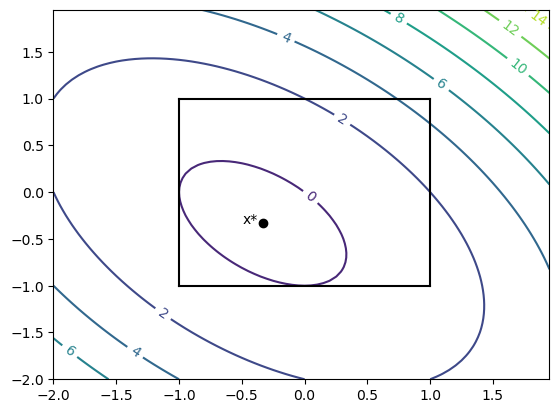

In [16]:
H = np.matrix('2 1; 1 2')
f = np.matrix('1; 1')
L =  np.matrix('[-1 1; -1 1]')

x = np.transpose(np.matrix([0, 0], dtype = np.float64))
plotContour(Example1(H, f), 0.05, [L[0,0]-1, L[0,1]+1], [L[1,0]-1, L[1,1]+1], True, L)

2. The unconstrained optimal solution is outside the area, i.e., it violates the constraints, so it is infeasible. 
        - The solution will be by the boundary of one or more constraints
        - We need a new approach to solve this problem.

x* = [-1.6667, -0.6667, -4.3333]


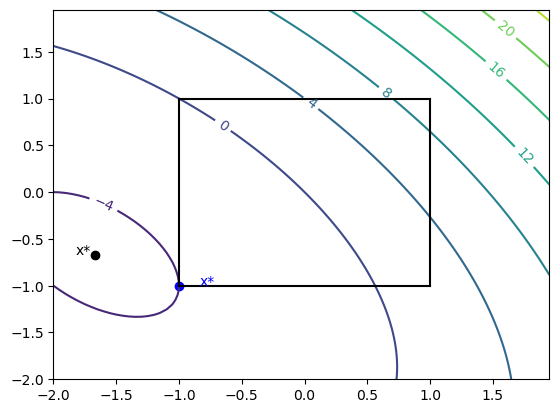

In [17]:
H = np.matrix('2 1; 1 2')
f = np.matrix('4; 3')
L =  np.matrix('[-1 1; -1 1]')

x = np.transpose(np.matrix([0, 0], dtype = np.float64))
plotContour(Example1(H, f), 0.05, [L[0,0]-1, L[0,1]+1], [L[1,0]-1, L[1,1]+1], True, L, np.matrix([-1, -1, -4]))

[Back to top](#EEEN30101-Numerical-Analysis)

### Barrier functions

There are various algorithms that can be used to solve quadratic programming problems. We will use one of the most established approaches, namely the **interior point algorithm**.

For this purpose, we need to reformulate our problem by adding barrier functions ($B(\underline(x))$ to our original problem as follows:

$$J(\underline{x}) = \frac{1}{2}\underline{x}^T \underline{\underline{H}}\underline{x} + \underline{f}^T\underline{x} + \mu B(\underline{x})$$

$$ B(\underline{x}) = - \sum_{i=1}^N {ln \left(1-\frac{x_i^2}{b^2} \right)} \quad \text{Barrier function}$$

For convenience, we will code this example in the python class below.

In [18]:
class ExampleBarrier:
    def __init__(self, H, f, mu, L):
        '''Initializing function'''
        self.H = H
        self.f = f
        self.mu = mu
        self.L = L
        self.No = len(f)
        self.x = np.zeros((self.No+1,1))

    def get_value(self, x):
        '''Get value of the function'''
        B = 0
        if x[0]<=self.L[0,0] or x[0]>=self.L[0,1] or x[1]<=self.L[1,0] or x[1]>=self.L[1,1]:
            J = 1e10+x[0]+x[1]
        else:
            J = 0.5 *np.matmul(np.transpose(x), np.matmul(self.H, x)) + \
                np.matmul(np.transpose(self.f), x)
            for i in range(2):
                if x[i] < 0:
                    B -= self.mu*np.log(1-x[i]**2/L[i,0]**2)
                else:
                    B -= self.mu*np.log(1-x[i]**2/L[i,1]**2)
        return J+B

    def get_optimal(self):
        '''Get optimal value'''
        Hi = np.linalg.inv(self.H)
        self.x[0:self.No] = - np.matmul(Hi, self.f)
        self.x[self.No] = - 0.5 *np.matmul(np.transpose(self.f),np.matmul(Hi,self.f))

        return self.x

The barrier functions introduce large values which tend to infinity as a solution approaches the constraints. As a result, the optimisation remains below the barrier with the aim of minimising the function.

Use the python method below to analyse the characteristics of the barrier functions.

In [19]:
@interact
def TestBarrier(L1 = widgets.FloatSlider(min=-5, max = -1, value=-2, description='Barrier1:', continuous_update=False),
                L2 = widgets.FloatSlider(min=1, max = 5, value=3, description='Barrier2:', continuous_update=False),
                mu = widgets.BoundedFloatText(min=0.0000001, max = 1, value=0.1, description='Threshold')):
    ''' Plot barrier functions '''
    L = [min(L1, L2), max(L1,L2)]
    x = np.linspace(L[0]+0.00001, L[1]-0.00001,100)
    X = np.zeros((2,100))
    X[0] = x
    X[1] = x

    Y = np.zeros((2,100))
    for i in range(100):
        for j in range(2):
            if x[i]/L[j] > 0:
                Y[j, i] = - mu*math.log(1 - (x[i]/L[j])**2)
    plotFigure(X, Y, ['Barrier 1', 'Barrier 2'], 'x', 'J(x)')

interactive(children=(FloatSlider(value=-2.0, continuous_update=False, description='Barrier1:', max=-1.0, min=…

Based on the outputs of the simulation, we can observe that:

- The barrier function prevent the solution to exceed the constraints

$$ \text{as} \quad B(\underline{x}) \longrightarrow \infty \quad as \quad \underline{x} \; \text{approaches the constraints}$$

- The $\mu$ parameter has to be gradually reduced to allow the solution to approach the constraints:

$$ \text{as} \quad \mu \longrightarrow 0 \quad \quad B(\underline{x}) \longrightarrow 0 \quad \text{ everywhere between the constraints}$$

[Back to top](#EEEN30101-Numerical-Analysis)

### Interior point algorithm

Based on the characteristics of the barrier function, we can deduce that the optimal solution of our modified problem, $\underline{x}^*(\mu)$, will approximate the solution of the original problem, $\underline{x}^*$, subject to the constraints as $\mu$ tends to zero. That is:

$$x^*(\mu) \longrightarrow x^* \quad \text{ as: } \quad \mu \longrightarrow 0$$

We can now use the above observations to create a simple interior point algorithm:

**Interior point algorithm**

`WHILE mu > Threshold:`<br/>
`    Solve problem (e.g., using Newton searches)`<br/>
`    Reduce 𝜇`<br/>
`END-WHILE`

For convenience, the algorithm is coded as the following python method.

In [20]:
def intPoint(ex, SA, x, prt=False):
    '''Interior point search'''
    mult = [0, 0]
    while ex.mu > 0.001:
        ex.mu *= 0.5
        for i in range(10):
            df = -SA.get_step(ex, x)
            for i in range(2):
                if df[i] < 0:
                    mult[i] = (L[i, 0]-x[i])/df[i]
                else:
                    mult[i] = (L[i, 1]-x[i])/df[i]
            x1 = x + df*min(mult)
            
            x = goldenSearch(ex, x1, x)
    aux = [x.item(0), x.item(1), ex.get_value(x)]
    x = np.transpose(np.matrix(aux, dtype = np.float64))
    if prt:
        print('x* = [%.4f, %.4f, %.4f]'%(x[0], x[1], x[2]))
    return x

We can now analyse how the constrained solutions are obtained:

- when the optimal solution falls within the constraints:

In [21]:
H = np.matrix('2 1; 1 2')
f = np.matrix('1; 1')
L =  np.matrix('[-1 1; -1 1]')
ex3 = ExampleBarrier(H, f, 1000, L)

x = np.transpose(np.matrix([0, 0], dtype = np.float64))
intPoint(ex3, NewtonS(), x)
print('The constrained and unconstrained solutions are the same:')
plotContour(Example1(H, f), 0.05, [-2, 2], [-2, 2], True, L)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

[Back to top](#EEEN30101-Numerical-Analysis)

- when the optimal solution falls outside the constraints:

In [ ]:
H = np.matrix('2 1; 1 2')
f = np.matrix('4; 3')
L =  np.matrix('[-1 1; -1 1]')
ex4 = ExampleBarrier(H, f, 1000, L)

x = np.transpose(np.matrix([0, 0], dtype = np.float64))
print('Constrained solution:')
x_star = intPoint(ex4, NewtonS(), x, True)
print('Unconstrained solution:')
plotContour(Example1(H, f), 0.05, [-2, 2], [-2, 2], True, L, x_star)

And we can also analyse how the solution is affected if the binding constraints are modified.

In [ ]:
xLimit = -1.5

In [ ]:
H = np.matrix('2 1; 1 2')
f = np.matrix('4; 3')
L =  np.matrix([[xLimit, 1],[-1, 1]])
ex5 = ExampleBarrier(H, f, 1000, L)

x = np.transpose(np.matrix([0, 0], dtype = np.float64))
print('Constrained solution:')
x_star = intPoint(ex5, NewtonS(), x, True)
print('Unconstrained solution:')
plotContour(Example1(H, f), 0.05, [-2, 2], [-2, 2], True, L, x_star)

[Back to top](#EEEN30101-Numerical-Analysis)

### Convexity

It is important to note that the constrained problems we have been solving so far are convex, that is, the function have a curved surface similar to the interior of a circle as presented in the figure below.

In [ ]:
x = np.zeros((1,100))
y = np.ones((1,100))
x[0] = np.linspace(-8,8.5,100)
y[0] = polynomial(x[0], [500, -24, 48])

X = np.zeros((4,1))
Y = np.zeros((4,1))
X[:,0] = [-7.5, 2.5, 8, 2.5]
Y[:,0] = [3380, 740, 3380, 3380]
Label1 = ['a', 'c', 'b', ' ']
Label2 = ["J(a)", "J(c)", "J(b)", "(1-λ)J(a)+λJ(b)"]

plotFullFigures(X, Y, Label1, Label2, 'x', 'J(x)', x, y, ['Convex function'])

Convexity can also me expressed mathematically. For that purpose consider the points presented in the figure above, namely $a$ and $b$


- We will also consider a point $c$ which is located between points $a$ and $b$:


$$c = (1 - \lambda) a + \lambda b \quad 0 \leq \lambda \leq 1$$


- If we were to project a line between $J(a)$ and $J(b)$, the value of the line above $c$ would be:

$$ (1 - \lambda) J(a) + \lambda J(b)$$

Now, for $J$ to be convex, we need the value of the function at any point $c$ to be below the $(1 - \lambda) J(a) + \lambda J(b)$ line for any combination of pairs $(a,b)$:

$$J(c) \leq (1 - \lambda) J(a) + \lambda J(b) \quad \text{for all pairs }(a,b)$$

Let us now add a constraint to our problem, to create a constraint region. We will also pick two points $(a,b)$ and draw a line between those points.

In [ ]:
x = np.zeros((3,100))
y = np.ones((3,100))
x[0] = np.linspace(-8,8.5,100)
x[1] = x[0]
x[2] = np.linspace(-3, 5,100)
y[0] = polynomial(x[0], [500, -24, 48])
y[1] = polynomial(x[1], [3700])
y[2] = polynomial(x[2], [2062.5, 187.5])

X = np.zeros((2,1))
Y = np.zeros((2,1))
X[:,0] = [-3, 5]
Y[:,0] = [1500, 3000]
Label1 = ['', '']
Label2 = ["a", "b"]

plotFullFigures(X, Y, Label1, Label2, 'x', 'J(x)', x, y, ['Convex function', 'Constraint', 'Line a-b'])

This constraint region is still convex as, as long as the points $a$ and $b$ are inside the constrained region, all parts of the lines formed by any pairs $(a,b)$ will also be inside the constrained region.

[Back to top](#EEEN30101-Numerical-Analysis)

## Non-convex optimisation

In this section we will explore non-convex optimisation problems, and introduce a new family of optimisation approaches.

So far, we have been solving optimisation problems through the manipulation of mathematical equations (e.g., objective functions and constraints) to guarantee finding **globally or locally optimal solutions**. Such family of optimisation approaches are generally called **mathematical programming** approaches.

The examples solved so far have been convex, which made mathematical programming relatively *easy* to implement. However, we would need to develop more advanced mathematical programming approaches to solve non-convex optimisation problems.

Instead, we will explore **metaheuristic** approaches, which are based on the application of heuristics, known to be successful for different process (e.g., evolution, process of heating materials, etc.), to find **good solutions** to our problems.

### Non-convex functions

As we discussed in a previous subsection, an optimisation problem will only be convex if you can draw lines between any pairs of points $(a, b)$ within the constraint region (or on top of the objective function) and all part of the lines remain inside the region.

Accordingly, as illustrated below, a problem will be non-convex if any part of any line is outside of the region or below the objective function. 

In [ ]:
x = np.zeros((2,100))
y = np.ones((2,100))
x[0] = np.linspace(0,6,100)
y[0] = polynomial(x[0], [40, -30, 30, -10, 1])
x[1] = np.linspace(1,5,100)
y[1] = polynomial(x[1], [45, -5])

X = np.zeros((2,1))
Y = np.zeros((2,1))
X[:,0] = [1, 5]
Y[:,0] = [40, 20]
Label1 = ['', '']
Label2 = ["a", "b"]

plotFullFigures(X, Y, Label1, Label2, 'x', 'J(x)', x, y, ['Non-convex function', 'Line a-b'])

You should remember that these types of problems are difficult to solve because:

><mark>Often, it is easy to find a local minimum</mark>

><mark>It is hard to guarantee we have found $x^*$</mark>

For example, consider the figure below, if our current guess of the solution ($x_k$) is in the vicinity of a local optimum, the gradient based searches we have used so far (e.g., steepest descent, and Newton's method) will lead us to the local optimum.

In [ ]:
K2 = [40, -30, 30, -10, 1]
x = np.zeros((1,100))
x[0] = np.linspace(0,6,100)
y[0] = polynomial(x[0], K2)

X = np.zeros((3,1))
Y = np.zeros((3,1))
X[:,0] = [0.7587, 4.5855, 2]
Y[:,0] = [30.47184352, 11.18167278, 36]
Label1 = ['', '', '']
Label2 = ["x* local", "x* global", 'xk']

plotFullFigures(X, Y, Label1, Label2, 'x', 'J(x)', x, y, ['Non-convex function', 'Line a-b'])

><mark>We need an approach to escape local optima in non-convex optimisation problems</mark>

[Back to top](#EEEN30101-Numerical-Analysis)

### Simulated annealing

To solve our non-convex problem in a relatively **easy** way, let us explore the metaheuristic family of optimisation approaches.

Metaheuristics generally use known heuristics to find good solutions to a problem, for example:
- Evolutionary algorithms use heuristics from evolution (e.g., reproduction, mutation, etc.).
- Particle swarm optimisation use heuristics from swarms (e.g., behaviour of birds or fish).
- Ant colony algorithms are based on heuristics used by ants to find food (e.g., use of pheromones).

In this particular section, we will use the simulated annealing algorithm, which is based on the process of heating and cooling down of materials. That is, the material is highly malleable and can take different shapes while it is hot, but it becomes more rigid and sets on a specific shape when as it cools down.

Let us illustrate the use of simulated annealing by applying it to find the optimal solution for the polynomial function presented in the figure above. We already know the optimal solution of that problem, $x^* = 4.5855$.

- Assume the material is our current solution ($x_k$), and we want to shape it into a globally optimal solution ($x^*$). To get an initial solution, we will randomly guess a value.

In [ ]:
x = 6*np.random.rand(1)[0]
J = polynomial([x], K2)
print('Our initial guess is %.4f'%x)
print('It has a cost of %.4f'%J)

- We will heat up our material to a high temperature ($T$), which will allow it to randomly change its shape ($\Delta x$).

In [ ]:
T = 100


- We will mould the changes by constraining them to be within a given set ($\Delta x \; \in \; \mathbb{M}$).

In [ ]:
M = 3
Δ𝑥 = M*(np.random.rand(1)[0]-0.5)
xnew = x+Δ𝑥
Jnew = polynomial([xnew], K2)
print('The new proposed solution is %.4f'%xnew)
print('It has a cost of %.4f'%Jnew)

[Back to top](#EEEN30101-Numerical-Analysis)

- If the random change would improve the shape of the material (i.e., offer a lower cost $J(x)$), we assume the material changed successfully.

In [ ]:
if Jnew < J:
    print('The new solution is better so the material is assumed to change')
    J = Jnew
    x = xnew
else:
    print('The new solution is not better so we are still unsure if the material changed')

- If the random change would not improve the shape of the material, it may still change. This is taken as a random process where the change is more likely to occur if the temperature of the material is high.

In [ ]:
prb = math.exp(-(Jnew-J)/T)
if Jnew < J:
    print('Even if the new solution was not better,')
elif np.random.rand(1)[0] < math.exp(-(Jnew-J)/T):
    print('The material is still assumed to change because')
    J = Jnew
    x = xnew
print('at the current temperature of %.2f'%T)
print('the probability that the material will change is %.4f%%'%(prb*100))

- The procedure is repeated but, as the material slowly cools down, it is less likely to change, and it eventually stops changing.

In [ ]:
def SiAn(x, J, T, M, ΔT, K2):
    k = 0
    while T>0.0001:
        k += 1
        T *= ΔT

        Δ𝑥 = M*(np.random.rand(1)[0]-0.5)
        xnew = x+Δ𝑥
        Jnew = polynomial([xnew], K2)

        if Jnew < J:
            J = Jnew
            x = xnew
        elif np.random.rand(1)[0] < math.exp(-(Jnew-J)/T):
            J = Jnew
            x = xnew
    return x, k

x, k = SiAn(x, J, T, M, 0.999, K2)
print('The solution converged to %.4f in %d iterations'%(x,k))

As shown above, metaheuristics such as simulated annealing tend to:
- offer **good** solutions, 
- but they may require calibration (e.g., $\mathbb{M}$ and initial $T$), and 
- it can be challenging to guarantee global optimality. 

Use the python method below to further explore the characteristics of the simulated annealing algorithm, especially the role of calibration.

In [ ]:
@interact
def TestSA1(M = widgets.FloatSlider(min=0, max = 3, value=1, description='M:', continuous_update=False),
            T = widgets.FloatSlider(min=0, max = 5, value=1, description='T:', continuous_update=False),
            ΔT = widgets.BoundedFloatText(min=0.1, max = 0.99999, value=0.99, description='ΔT')):
    ''' Test 1 for simulated annealing '''
    print('Performing 10 sets of simulations')
    for i in range(10):
        x = 6*np.random.rand(1)[0]
        J = polynomial([x], K2)
        x, k = SiAn(x, J, T, M, ΔT, K2)
        print('Solution %2.0f converged to %.4f in %d iterations'%(i+1, x, k))
    print('\nRemember that the global optimum is 4.5855')
    

><mark>Metaheuristic algorithms need calibration to consistently produce good results at relatively low computational costs.</mark>

[Back to top](#EEEN30101-Numerical-Analysis)

### Algorithm

As presented above, the simulated annealing algorithm requires some customisation (especially in $x$ and $\mathbb{M}$) to be applied to specific problems.

Regardless, there are some general algorithms that we can use such as the Metropolis algorithm presented below.

**Metropolis algorithm**

` Given an initial x, a move class 𝕄 and a "temperature" T,`<br/>

`WHILE stopping criterion not met`<br/>
`    Choose a Δx from M at random`<br/>
`    ΔJ = J(x + Δx) - J(x)`<br/>
`    IF ΔJ < 0`<br/>
`        x := x + Δx`<br/>
`    ELSE generate a uniform random number R on [0; 1]`<br/>
`        IF R < exp(-ΔJ/T )`<br/>
`            x := x + Δx`<br/>
`        END IF`<br/>
`    END IF`<br/>
`END WHILE`

Let us develop this algorithm to solve **Problem 4**, which is a typical travelling salesman problem.

The travelling salesman problem involves finding a path that offers the shortest distance to visit different locations. In practice, there are many applications of this problem, such as to find short distance paths to deliver goods, expand a power system, restore electricity supply to our customers, etc.

In this particular example, our objective is to visit six local football clubs, namely Accrington Stanley, Blackburn Rovers, Bolton Wanderers, Burnley, Everton, and Preston North End (see figure below).

In [ ]:
def showClubs(club, x_star=[]):
    '''Show football clubs'''
    XY = [[42, 16],[33.1, 19],[25, 5.51],[46.2, 20],[0, 0],[22.9, 27]]
    
    if len(x_star) == 0:
        x = np.zeros((1,100))
        y = np.zeros((1,100))
        Legends = ['']
    else:
        Legends = ['Path01','Path02','Path03','Path04','Path05']
        x = np.zeros((5,100))
        y = np.zeros((5,100))
        for i in range(5):
            x[i] = np.linspace(XY[x_star[i]][0],XY[x_star[i+1]][0],100)
            for j in range(100):
                y[i][j] = XY[x_star[i]][1] + \
                    (XY[x_star[i+1]][1]-XY[x_star[i]][1]) /\
                    (XY[x_star[i+1]][0]-XY[x_star[i]][0])* \
                    (x[i][j]-XY[x_star[i]][0])
    
    X = np.zeros((6,1))
    Y = np.zeros((6,1))
    X[:,0] = [XY[0][0], XY[1][0], XY[2][0], XY[3][0], XY[4][0], XY[5][0]]
    Y[:,0] = [XY[0][1], XY[1][1], XY[2][1], XY[3][1], XY[4][1], XY[5][1]]
    Label2 = club
    Label1 = [" ", " ", " ", " ", " ", " "]

    plotFullFigures(X, Y, Label1, Label2, 'x', 'J(x)', x, y, Legends)
club = ['Accrington Stanley', 'Blackburn Rovers', 'Bolton Wanderers', 'Burnley', 'Everton', 'Preston North End']
showClubs(club)

[Back to top](#EEEN30101-Numerical-Analysis)

- The first step is to define how an answer ($x$) should look like. 

$\quad$ For this purpose, we first assign numbers to each location:

    0. Accrington Stanley 
    1. Blackburn Rovers
    2. Bolton Wanderers
    3. Burnley 
    4. Everton 
    5. Preston North End

$\quad$ And define our answer as a sequence of numbers. 

$\quad$ For example, the path Everton - Accrington - Preston - Burnley - Blackburn - Bolton becomes:

$$x = [4, 0, 5, 3, 1, 2] $$

In [ ]:
x = [4, 0, 5, 3, 1, 2]
showClubs(club, x)

***It is important to note that this problem is non-convex because the problem is not continuous. That is, even though our solution can take integer numbers such as 1 and 2, we cannot use any values between these numbers (e.g., 1.1, 1.5, 1.75, etc.).***

- Next, we need to define an objective function.

$\quad$ Our objective function is to minimise the distance of our solution, that is:

$$J(x) = \sum_i^6{distance_{x_i,x_{i+1}}}$$

$\quad$ Where $distance$ is a matrix representing distances between sites corresponding to its rows and columns:


|                    | Accrington Stanley | Blackburn Rovers | Bolton Wanderers | Burnley | Everton | Preston North End |
|--------------------|--------------------|------------------|------------------|---------|---------|-------------------|
| Accrington Stanley |  0                 |       8.9        |       25.8       |   8.8   |   44.6  |     15.7          |
| Blackburn Rovers   |  8.9               |       0          |       15.7       |   14.6  |   38.2  |     13.8          |
| Bolton Wanderers   |  25.8              |       15.7       |       0          |   31.4  |   25.6  |     17.9          |
| Burnley            |  8.8               |       14.6       |       31.4       |   0     |   50.3  |     21.3          |
| Everton            |  44.6              |       38.2       |       25.6       |   50.6  |   0     |     35.4          |
| Preston North End  |  15.7              |       13.8       |       17.9       |   21.3  |   35.4  |     0             |

In [ ]:
M =[[0, 8.9, 25.8, 8.8, 44.6, 15.7],
    [8.9, 0, 15.7, 14.6, 38.2, 13.8],
    [25.8, 15.7, 0, 31.4, 25.6, 17.9],
    [8.8, 14.6, 31.4, 0, 50.3, 21.3],
    [44.6, 38.2, 25.6, 50.3, 0, 35.4],
    [15.7, 13.8, 17.9, 21.3, 35.4, 0]]

- Finally, we need a process to update our current solution, i.e., $\Delta x \; \in \; \mathbb{M}$.

$\quad$ As our solution will always contain the same numbers, it can be updated by changing their order.

$\quad$ Accordingly, we introduce a process to reverse the order of some elements of $x$. This is illustrated with the python code below.

[Back to top](#EEEN30101-Numerical-Analysis)

In [ ]:
def prntX(x):
    print('Position:', end='')
    for i in range(6):
        print('%3.0f'%i, end='')
    print('\nValue   :', end='')
    for i in range(6):
        print('%3.0f'%x[i], end='')
    print()

@interact
def TestSA1(a = widgets.IntSlider(min=0, max = 4, value=2, description='a:', continuous_update=False),
            b = widgets.IntSlider(min=1, max = 5, value=4, description='b:', continuous_update=False)):
    ''' Test 1 for simulated annealing '''
    if a > b:
        aux = a
        a = b
        b = aux
    print('Change the order of the solution between positions a and b\n')
    x = [0, 1, 2, 3, 4, 5]
    print('Original solution')
    prntX(x)
    
    ind = copy.deepcopy(x) 
    ind[int(a):int(b+1)] = np.flip(x[int(a):int(b+1)])
    x = ind
    print('\nUpdated solution')
    prntX(x)

We can now deploy our algorithm and solve the problem:

In [ ]:
def simAnn(M, club, prt=False):
    '''Simulated annealing'''
    def getOF(M, x):
        '''Calculate objective function'''
        J = 0
        for i in range(len(x)-1):
            J += M[x[i]][x[i+1]]
        return J

    s = len(club)
    x = [i for i in range(s)]
    J = getOF(M, x)
    
    JJ = []
    JJ.append(J)
    T = 100
    k = 1
    while T>0.0001:
        mov = np.random.randint(0, s, (2, 1), dtype=int)
        if mov[0] != mov[1]:
            if mov[0] > mov[1]:
                mov = np.flip(mov)
            ind = copy.deepcopy(x) 
            ind[int(mov[0]):int(mov[1]+1)] = np.flip(x[int(mov[0]):int(mov[1]+1)])
            xnew = ind
            Jnew = getOF(M, xnew)
            if Jnew < J:
                x = xnew
                J = Jnew
                JJ.append(J)
                k += 1
            else:
                R = np.random.rand(1)[0]
                if R < math.exp(-(Jnew-J)/T):
                    x = xnew
                    J = Jnew
                    JJ.append(J)
                    k += 1
            T *= 0.999
    if prt:
        print('The optimal route is:')
        for i in range(s):
            print('\t',club[x[i]])
        print('With a total distance of %f'%J)
    return x
x = simAnn(M, club, True)
showClubs(club, x)

[Back to top](#EEEN30101-Numerical-Analysis)

## Conclusion

At the end of this week's lecture and after going through this (part 02) and the previous (part 01) notebooks, you should be able to address the following questions:<br/>
- Analysis of search algorithms using Rosenbrock's banana function<br/>
      - What is the banana function typically used for and why?<br/>
      - What are the differences between steepest descent and Newton’s searches?<br/><br/>
- Constrained optimisation<br/>
      - Why would we need to add constraints to an optimisation problem?<br/>
      - What is a barrier function?<br/>
      - How do you apply the interior point algorithm?<br/><br/>
- Non-convex optimisation<br/>
      - What are the characteristics of convex and non-convex optimisation problems?<br/>
      - Why are non-convex problems more difficult to solve than convex problems?<br/>
      - How do you apply the simulated annealing algorithm?

If you cannot answer these questions, you may want to check again the notebook and the lecture notes. 

[Back to top](#EEEN30101-Numerical-Analysis)